# Task 4
This serves as a template which will guide you through the implementation of this task. It is advised to first read the whole template and get a sense of the overall structure of the code before trying to fill in any of the TODO gaps.
This is the jupyter notebook version of the template. For the python file version, please refer to the file `template_solution.py`.

First, we import necessary libraries:

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# Add any other imports you need here
from transformers import AutoTokenizer, DistilBertModel
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PATH = '/kaggle/input/project4-data/'
print(DEVICE)
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

cuda:0


Depending on your approach, you might need to adapt the structure of this template or parts not marked by TODOs.
It is not necessary to completely follow this template. Feel free to add more code and delete any parts that are not required.

In [2]:
BATCH_SIZE = 256  # TODO: Set the batch size according to both training performance and available memory
NUM_EPOCHS = 20  # TODO: Set the number of epochs

train_val = pd.read_csv(PATH + "train.csv")
test_val = pd.read_csv(PATH + "test_no_score.csv")

In [3]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english").to(DEVICE)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

<h1>Preprocessing of DataFrame</h1>

In [4]:
# preprocess a single row of dataframe
# rules of preprocessing is as follows:
# first tokenize both title and sentence section of the row
# then extract transformer embeddings of both tokenization results
# next concatenate the embeddings into the form title:sentence
# add paddings to the embeddings to make them uniform in shape
# finally put the result into the "embedding" column of the row
# print(model)
def preprocess_row(row):
    title = row['title']
    sentence = row['sentence']
    with torch.no_grad():
        inputs = tokenizer(title, return_tensors="pt").to(DEVICE)
        title_embedding = distilbert(**inputs).last_hidden_state
        inputs = tokenizer(sentence, return_tensors="pt").to(DEVICE)
        sentence_embedding = distilbert(**inputs).last_hidden_state
        
        embedding = torch.cat((title_embedding, sentence_embedding), dim=1)
        embedding = embedding.detach().squeeze()

        padding = torch.zeros((320 - embedding.shape[0], 768)).to(DEVICE)
        # print row number and shape of embedding and padding
        print(row.name, embedding.shape, padding.shape)
        # print(embedding)
        embedding = torch.cat((embedding, padding), dim=0)
        embedding = embedding.cpu().numpy() # convert to numpy array to be able to save it as a csv file
        embedding = np.reshape(embedding, (320*768))
#         print(embedding)
        row['embedding'] = embedding
    return row

In [5]:
train_val = train_val.apply(preprocess_row, axis=1)

0 torch.Size([56, 768]) torch.Size([264, 768])
1 torch.Size([74, 768]) torch.Size([246, 768])
2 torch.Size([37, 768]) torch.Size([283, 768])
3 torch.Size([35, 768]) torch.Size([285, 768])
4 torch.Size([94, 768]) torch.Size([226, 768])
5 torch.Size([120, 768]) torch.Size([200, 768])
6 torch.Size([124, 768]) torch.Size([196, 768])
7 torch.Size([239, 768]) torch.Size([81, 768])
8 torch.Size([54, 768]) torch.Size([266, 768])
9 torch.Size([200, 768]) torch.Size([120, 768])
10 torch.Size([200, 768]) torch.Size([120, 768])
11 torch.Size([212, 768]) torch.Size([108, 768])
12 torch.Size([173, 768]) torch.Size([147, 768])
13 torch.Size([147, 768]) torch.Size([173, 768])
14 torch.Size([82, 768]) torch.Size([238, 768])
15 torch.Size([53, 768]) torch.Size([267, 768])
16 torch.Size([225, 768]) torch.Size([95, 768])
17 torch.Size([158, 768]) torch.Size([162, 768])
18 torch.Size([71, 768]) torch.Size([249, 768])
19 torch.Size([99, 768]) torch.Size([221, 768])
20 torch.Size([116, 768]) torch.Size([204,

In [6]:
train_val.iloc[0]["embedding"]

array([-0.59172195,  0.56775355,  0.05636277, ...,  0.        ,
        0.        ,  0.        ], dtype=float32)

In [7]:
from matplotlib import pyplot as plt

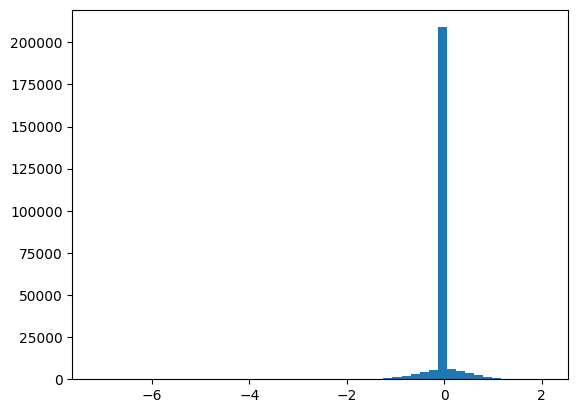

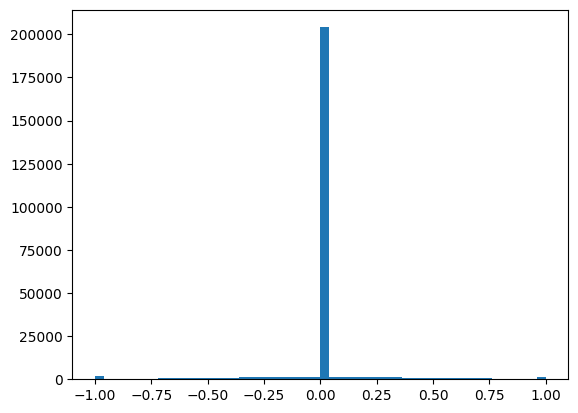

In [12]:
e = train_val.iloc[0]["embedding"]
plt.hist(e, bins=50)
plt.show()
e_clamped = np.clip(e, -1, 1)
plt.hist(e_clamped, bins=50)
plt.show()

In [7]:
train_val.iloc[0]

title                                not really sayin anything
sentence     this movie is ok but its not teachin anything ...
score                                                 4.657854
embedding    [-0.59172195, 0.56775355, 0.05636277, -0.24751...
Name: 0, dtype: object

In [8]:
# TODO: Fill out ReviewDataset
class ReviewDataset(Dataset):
    def __init__(self, data_frame, train=True):
        self.dataframe = data_frame
        self.train = train

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        item = self.dataframe.iloc[index]
        if self.train:
            return self.clipping_normalize(item["embedding"]), item["score"]
        return self.clipping_normalize(item["embedding"])
    
    def clipping_normalize(self, embedding):
        return np.clip(embedding, -1, 1)


In [9]:
train_dataset = ReviewDataset(train_val)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=4, pin_memory=True)
# Additional code if needed

In [10]:
# TODO: Fill out MyModule
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0 = nn.BatchNorm1d(245760)
        self.fc0 = nn.Linear(245760, 2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.fc1 = nn.Linear(2048, 1)
        nn.init.kaiming_normal_(self.fc0.weight, nonlinearity='sigmoid')
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='sigmoid')

    def forward(self, x):
        x = self.bn0(x)
        x = self.fc0(x)
        x = self.bn1(x)
        x = nn.functional.sigmoid(x)
        x = self.fc1(x)
#         x = nn.functional.sigmoid(x) * 10
        return x

In [12]:
NUM_EPOCHS = 5

# print(torch.cuda.memory_summary())
try:
    del model
    del optimizer
    del criterion
except NameError: pass
torch.cuda.empty_cache()

model = SimpleNN().to(DEVICE)
# print(torch.cuda.memory_summary())

# TODO: Setup loss function, optimiser, and scheduler
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

model.train()
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, total=len(train_loader)):
        inputs = inputs.to(DEVICE)
        labels = labels.float().unsqueeze(1).to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
#         print(outputs.dtype, labels.dtype)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)  # Multiply by batch size
#         print(running_loss)
        
        del inputs
        del labels
        del outputs
        del loss
        torch.cuda.empty_cache()
#     print("Epoch done,", running_loss)
    epoch_loss = running_loss / len(train_loader.dataset)  # Divide by total dataset size
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss}")

    scheduler.step(epoch_loss)  # Scheduler step with epoch loss as argument

100%|██████████| 49/49 [00:15<00:00,  3.24it/s]


Epoch [1/5], Loss: 8.919978843917846


100%|██████████| 49/49 [00:15<00:00,  3.26it/s]


Epoch [2/5], Loss: 2.894027202301025


100%|██████████| 49/49 [00:15<00:00,  3.23it/s]


Epoch [3/5], Loss: 2.334352621307373


100%|██████████| 49/49 [00:14<00:00,  3.28it/s]


Epoch [4/5], Loss: 1.9747402459716796


100%|██████████| 49/49 [00:15<00:00,  3.21it/s]

Epoch [5/5], Loss: 1.7694000355911255


<h1>Test</h1>

In [13]:
test_val = test_val.apply(preprocess_row, axis=1)
test_dataset = ReviewDataset(test_val, train=False)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=4, pin_memory=True)

0 torch.Size([114, 768]) torch.Size([206, 768])
1 torch.Size([156, 768]) torch.Size([164, 768])
2 torch.Size([196, 768]) torch.Size([124, 768])
3 torch.Size([101, 768]) torch.Size([219, 768])
4 torch.Size([54, 768]) torch.Size([266, 768])
5 torch.Size([45, 768]) torch.Size([275, 768])
6 torch.Size([115, 768]) torch.Size([205, 768])
7 torch.Size([115, 768]) torch.Size([205, 768])
8 torch.Size([51, 768]) torch.Size([269, 768])
9 torch.Size([65, 768]) torch.Size([255, 768])
10 torch.Size([157, 768]) torch.Size([163, 768])
11 torch.Size([179, 768]) torch.Size([141, 768])
12 torch.Size([29, 768]) torch.Size([291, 768])
13 torch.Size([238, 768]) torch.Size([82, 768])
14 torch.Size([183, 768]) torch.Size([137, 768])
15 torch.Size([215, 768]) torch.Size([105, 768])
16 torch.Size([214, 768]) torch.Size([106, 768])
17 torch.Size([61, 768]) torch.Size([259, 768])
18 torch.Size([53, 768]) torch.Size([267, 768])
19 torch.Size([102, 768]) torch.Size([218, 768])
20 torch.Size([254, 768]) torch.Size([

In [14]:
model.eval()
with torch.no_grad():
    results = []
    for inputs in tqdm(test_loader, total=len(test_loader)):
        # print(inputs.shape)
        inputs = inputs.to(DEVICE)
        with torch.no_grad():
            outputs = model(inputs)
            print(outputs)
            results.append(outputs.cpu())
    results = np.vstack(results)
    with open("/kaggle/working/result.txt", "w") as f:
        for val in np.concatenate(results):
            f.write(f"{val}\n")

 50%|█████     | 2/4 [00:01<00:01,  1.29it/s]

tensor([[ 1.8016],
        [ 9.8574],
        [ 4.4969],
        [ 4.4637],
        [ 6.2555],
        [ 5.9406],
        [ 8.1892],
        [ 5.5154],
        [ 5.0580],
        [ 7.6272],
        [ 9.1689],
        [ 3.5797],
        [ 7.8032],
        [-0.3664],
        [ 1.1546],
        [ 4.4080],
        [ 4.3406],
        [ 6.3676],
        [ 9.6194],
        [ 2.1848],
        [ 5.0183],
        [ 0.4068],
        [ 5.3821],
        [ 8.2790],
        [10.0336],
        [ 7.5421],
        [ 9.4289],
        [ 3.5992],
        [ 3.1360],
        [ 1.7433],
        [ 4.0571],
        [ 3.9622],
        [ 7.8372],
        [ 6.3254],
        [ 6.1630],
        [ 5.6555],
        [10.4346],
        [ 0.0836],
        [ 6.2521],
        [ 2.8437],
        [ 9.7763],
        [ 7.9065],
        [ 4.5419],
        [ 2.6349],
        [10.3150],
        [ 9.9957],
        [ 3.6332],
        [ 5.9144],
        [ 2.3731],
        [ 2.7735],
        [ 7.6207],
        [ 9.2463],
        [10.

100%|██████████| 4/4 [00:02<00:00,  2.91it/s]

tensor([[ 2.9467],
        [ 9.0016],
        [ 3.4728],
        [ 7.4658],
        [ 2.9793],
        [ 6.6633],
        [ 4.1654],
        [ 7.3951],
        [ 3.0151],
        [ 9.3334],
        [ 2.8230],
        [ 3.2349],
        [ 2.7072],
        [ 3.2864],
        [ 8.3297],
        [ 3.0252],
        [ 1.0798],
        [ 9.5674],
        [ 3.7620],
        [ 3.4162],
        [ 8.7632],
        [ 0.0495],
        [ 6.5792],
        [ 3.3698],
        [ 8.6457],
        [ 2.9172],
        [ 4.0506],
        [ 4.8198],
        [ 5.1812],
        [ 8.9463],
        [ 0.2260],
        [ 0.6223],
        [ 4.3627],
        [ 8.7382],
        [ 3.2936],
        [ 4.9843],
        [ 5.8926],
        [ 3.4556],
        [ 0.5165],
        [ 9.7855],
        [ 5.7776],
        [ 7.2965],
        [ 7.0146],
        [ 8.9844],
        [ 2.9602],
        [ 2.3801],
        [ 2.9890],
        [ 7.8876],
        [ 2.7965],
        [ 7.5294],
        [ 9.7967],
        [ 4.2100],
        [ 2.

100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


<h1>Cleanup</h1>

In [12]:
del model
torch.cuda.empty_cache()

print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   8177 MiB |  10122 MiB |   6064 GiB |   6056 GiB |
|       from large pool |   8167 MiB |  10110 MiB |   4647 GiB |   4639 GiB |
|       from small pool |      9 MiB |     16 MiB |   1416 GiB |   1416 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   8177 MiB |  10122 MiB |   6064 GiB |   6056 GiB |
|       from large pool |   8167 MiB |  10110 MiB |   4647 GiB |